# [IDPP CLEF Challlenge](http://brainteaser.dei.unipd.it/challenges/idpp2023/)


In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
import lightgbm

# machine learning
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import r_regression
from sklearn import preprocessing

In [29]:
DATASET = "datasetA"
DATASET_DIR = f"../data/{DATASET}_train"

ID_FEAT = "patient_id"

pd.set_option('display.max_rows', None)

# Load and Merge data

In [30]:
def filenames_in_folder(dir_path):
    file_names = []
    for _, __, f_names in os.walk(dir_path):
        for file_name in f_names:
            file_names.append(file_name)
        break
    return file_names

def read_dfs(dir_path):
    file_names = filenames_in_folder(dir_path)
    dfs = {file_name.removesuffix(".csv"): pd.read_csv(os.path.join(dir_path, file_name)) for file_name in file_names if file_name.endswith("csv")}
    return dfs

def merge_csv_in_dir(dfs, dataset):

    def transpose_cols_to_rows_by_uniques(orig_df, id_feat, other_feature):
        transposed_df = pd.DataFrame(orig_df.groupby(id_feat)[other_feature].apply(lambda x: x.values).values.tolist(), index=orig_df[id_feat].unique())
        transposed_df.columns = [f'{other_feature}_{i:02d}' for i in range(1, len(transposed_df.columns) + 1)]
        return transposed_df

    def transpose_cols_to_rows_by_1st_unique(orig_df, id_feat, other_feature):
        transposed_df = pd.DataFrame(orig_df.groupby(id_feat)[other_feature].apply(lambda x: x.values[0]),
                         index=orig_df[id_feat].unique())
        return transposed_df

    def transpose_df_by_uniques(orig_df, id_feat, time_series_feats, one_occurrence_feats, sort_by_this_feat):
        orig_df = orig_df.sort_values(by=[ID_FEAT, sort_by_this_feat])
        ts_dfs = [transpose_cols_to_rows_by_uniques(orig_df, id_feat, ts_feat) for ts_feat in time_series_feats]
        oo_dfs = [transpose_cols_to_rows_by_1st_unique(orig_df, id_feat, oo_feat) for oo_feat in one_occurrence_feats]

        out_df = pd.concat([*oo_dfs, *ts_dfs], axis=1)
        out_df.reset_index(names=id_feat, inplace=True)
        return out_df

    merged_df = pd.merge(dfs[f"{dataset}_train-static-vars"], dfs[f"{dataset}_train-outcomes"],
                         on="patient_id", how="outer")

    relapses_df = dfs[f"{dataset}_train-relapses"]
    ts_feats = ["delta_relapse_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_relapse_time0"
    relapses_df = transpose_df_by_uniques(relapses_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    ms_type_df = dfs[f"{dataset}_train-ms-type"]
    ts_feats = ["multiple_sclerosis_type", "delta_observation_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_observation_time0"
    ms_type_df = transpose_df_by_uniques(ms_type_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    mri_df = dfs[f"{dataset}_train-mri"]
    ts_feats = ["mri_area_label", "lesions_T1", "lesions_T1_gadolinium", "number_of_lesions_T1_gadolinium",
                "new_or_enlarged_lesions_T2", "number_of_new_or_enlarged_lesions_T2", "lesions_T2", "number_of_total_lesions_T2", "delta_mri_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_mri_time0"
    mri_df = transpose_df_by_uniques(mri_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    evoked_p_df = dfs[f"{dataset}_train-evoked-potentials"]
    ts_feats = ["altered_potential", "potential_value", "location", "delta_evoked_potential_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_evoked_potential_time0"
    evoked_p_df = transpose_df_by_uniques(evoked_p_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)


    edss_df = dfs[f"{dataset}_train-edss"]
    ts_feats = ["edss_as_evaluated_by_clinician", "delta_edss_time0"]
    oo_feats = ["centre"]
    sort_by_this_feat = "delta_edss_time0"
    edss_df = transpose_df_by_uniques(edss_df, ID_FEAT, ts_feats, oo_feats, sort_by_this_feat)

    grouped_dfs = [edss_df, relapses_df, ms_type_df, evoked_p_df, mri_df]
    for df in grouped_dfs:
        merged_df = pd.merge(merged_df, df, on=[ID_FEAT, "centre"], how="outer")

    return merged_df

In [31]:
dfs = read_dfs(DATASET_DIR)
df = merge_csv_in_dir(dfs, DATASET)
df = df.dropna(axis=1, how="all")
print(df.columns.values)
df.head()

['patient_id' 'sex' 'residence_classification' 'ethnicity'
 'ms_in_pediatric_age' 'age_at_onset' 'diagnostic_delay'
 'spinal_cord_symptom' 'brainstem_symptom' 'eye_symptom'
 'supratentorial_symptom' 'other_symptoms' 'centre' 'time_since_onset'
 'outcome_occurred' 'outcome_time' 'edss_as_evaluated_by_clinician_01'
 'edss_as_evaluated_by_clinician_02' 'edss_as_evaluated_by_clinician_03'
 'edss_as_evaluated_by_clinician_04' 'edss_as_evaluated_by_clinician_05'
 'edss_as_evaluated_by_clinician_06' 'edss_as_evaluated_by_clinician_07'
 'edss_as_evaluated_by_clinician_08' 'edss_as_evaluated_by_clinician_09'
 'edss_as_evaluated_by_clinician_10' 'edss_as_evaluated_by_clinician_11'
 'edss_as_evaluated_by_clinician_12' 'edss_as_evaluated_by_clinician_13'
 'edss_as_evaluated_by_clinician_14' 'edss_as_evaluated_by_clinician_15'
 'edss_as_evaluated_by_clinician_16' 'edss_as_evaluated_by_clinician_17'
 'edss_as_evaluated_by_clinician_18' 'edss_as_evaluated_by_clinician_19'
 'edss_as_evaluated_by_clini

,patient_id,sex,residence_classification,ethnicity,ms_in_pediatric_age,age_at_onset,diagnostic_delay,spinal_cord_symptom,brainstem_symptom,eye_symptom,...,delta_mri_time0_03,delta_mri_time0_04,delta_mri_time0_05,delta_mri_time0_06,delta_mri_time0_07,delta_mri_time0_08,delta_mri_time0_09,delta_mri_time0_10,delta_mri_time0_11,delta_mri_time0_12
0,100381996772220382021070974955176218231,female,Towns,Caucasian,False,32,31.0,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100619256189067386770484450960632124211,female,Towns,Caucasian,False,26,18.0,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101600333961427115125266345521826407539,female,Towns,Caucasian,False,27,15.0,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,103223150270392058352370339153314674792,male,Towns,Caucasian,False,22,115.0,True,False,False,...,-775.0,-647.0,-403.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105832402762754925769934626962665975929,female,Rural Area,Caucasian,False,43,106.0,False,False,True,...,-380.0,-41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df.describe()

,age_at_onset,diagnostic_delay,time_since_onset,outcome_occurred,outcome_time,edss_as_evaluated_by_clinician_01,edss_as_evaluated_by_clinician_02,edss_as_evaluated_by_clinician_03,edss_as_evaluated_by_clinician_04,edss_as_evaluated_by_clinician_05,...,delta_mri_time0_03,delta_mri_time0_04,delta_mri_time0_05,delta_mri_time0_06,delta_mri_time0_07,delta_mri_time0_08,delta_mri_time0_09,delta_mri_time0_10,delta_mri_time0_11,delta_mri_time0_12
count,440.000000,428.000000,440.000000,440.000000,440.000000,439.000000,423.000000,390.000000,342.000000,285.000000,...,156.000000,114.000000,73.000000,47.000000,28.000000,18.000000,11.000000,6.000000,3.000000,1.0
mean,30.618182,1029.380841,2523.790909,0.165909,5.188088,1.787016,1.494090,1.456410,1.511696,1.549123,...,-450.698718,-371.289474,-315.684932,-286.574468,-255.571429,-202.277778,-225.090909,-251.166667,-167.333333,-198.0
std,9.427080,1727.805510,2448.298365,0.372422,4.423001,0.845801,0.739436,0.683554,0.717304,0.688978,...,256.612157,238.826879,207.755256,191.243044,201.481445,189.387187,167.888329,108.414790,127.249100,NaN
min,11.000000,1.000000,469.000000,0.000000,0.131507,0.000000,0.000000,0.000000,0.000000,0.000000,...,-893.000000,-849.000000,-815.000000,-667.000000,-641.000000,-609.000000,-452.000000,-441.000000,-267.000000,-198.0
25%,24.000000,123.000000,930.000000,0.000000,1.554795,1.500000,1.000000,1.000000,1.000000,1.000000,...,-662.750000,-580.250000,-462.000000,-412.500000,-433.250000,-344.750000,-377.500000,-276.000000,-239.000000,-198.0
50%,29.000000,320.000000,1436.000000,0.000000,3.472603,2.000000,1.500000,1.500000,1.500000,1.500000,...,-507.000000,-366.000000,-326.000000,-247.000000,-196.000000,-135.000000,-142.000000,-239.000000,-211.000000,-198.0
75%,37.000000,1102.250000,3091.000000,0.000000,8.440411,2.000000,2.000000,2.000000,2.000000,2.000000,...,-247.750000,-161.250000,-161.000000,-167.500000,-77.000000,-53.750000,-97.500000,-188.500000,-117.500000,-198.0
max,65.000000,12814.000000,14768.000000,1.000000,15.000000,6.000000,5.000000,3.000000,3.500000,4.000000,...,-3.000000,-3.000000,-11.000000,-8.000000,-7.000000,-6.000000,-15.000000,-128.000000,-24.000000,-198.0


In [33]:
print(df.columns.to_series().groupby(df.dtypes).groups)
df.info()

{bool: ['ms_in_pediatric_age', 'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom', 'supratentorial_symptom'], int64: ['age_at_onset', 'time_since_onset', 'outcome_occurred'], float64: ['diagnostic_delay', 'outcome_time', 'edss_as_evaluated_by_clinician_01', 'edss_as_evaluated_by_clinician_02', 'edss_as_evaluated_by_clinician_03', 'edss_as_evaluated_by_clinician_04', 'edss_as_evaluated_by_clinician_05', 'edss_as_evaluated_by_clinician_06', 'edss_as_evaluated_by_clinician_07', 'edss_as_evaluated_by_clinician_08', 'edss_as_evaluated_by_clinician_09', 'edss_as_evaluated_by_clinician_10', 'edss_as_evaluated_by_clinician_11', 'edss_as_evaluated_by_clinician_12', 'edss_as_evaluated_by_clinician_13', 'edss_as_evaluated_by_clinician_14', 'edss_as_evaluated_by_clinician_15', 'edss_as_evaluated_by_clinician_16', 'edss_as_evaluated_by_clinician_17', 'edss_as_evaluated_by_clinician_18', 'edss_as_evaluated_by_clinician_19', 'edss_as_evaluated_by_clinician_20', 'edss_as_evaluated_by_clinician_

In [34]:
missing_values = ((df.isnull().sum() * 100 / len(df)).sort_values(ascending=False))
print("Missing value rate:\n", missing_values.to_string())

Missing value rate:
 delta_mri_time0_12                         99.772727
delta_evoked_potential_time0_29            99.772727
delta_edss_time0_28                        99.772727
delta_edss_time0_27                        99.772727
delta_edss_time0_26                        99.772727
delta_edss_time0_25                        99.772727
delta_edss_time0_24                        99.772727
delta_evoked_potential_time0_26            99.772727
potential_value_26                         99.772727
potential_value_27                         99.772727
potential_value_28                         99.772727
potential_value_29                         99.772727
potential_value_30                         99.772727
new_or_enlarged_lesions_T2_12              99.772727
delta_evoked_potential_time0_30            99.772727
edss_as_evaluated_by_clinician_24          99.772727
edss_as_evaluated_by_clinician_25          99.772727
edss_as_evaluated_by_clinician_26          99.772727
edss_as_evaluated_by_clin

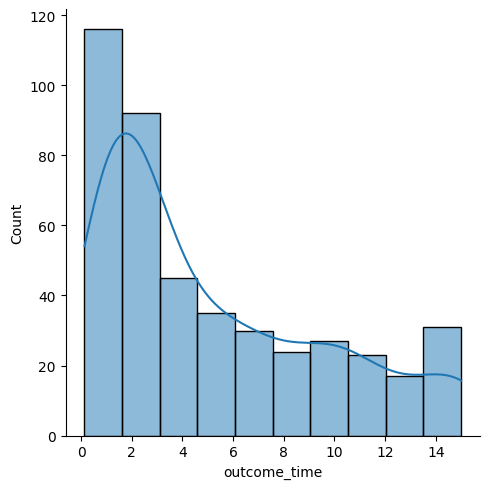

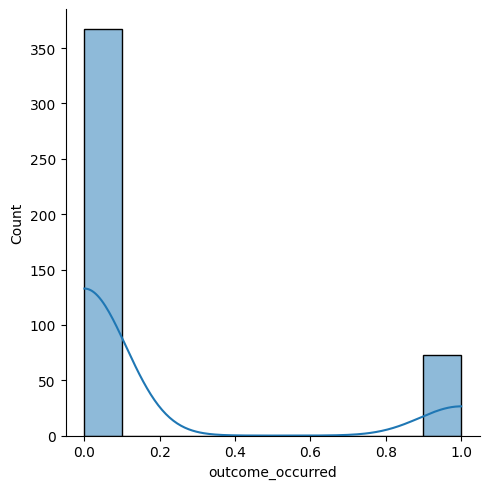

In [35]:
sns.displot(df["outcome_time"],kde=True, legend=True)
sns.displot(df["outcome_occurred"],kde=True, legend=True)


In [36]:
# corr_mat = df[continuous_values].corr()
# f, ax = plt.subplots(figsize=(20, 20))
# sns.heatmap(corr_mat,  vmax=1, cmap="viridis", square=True)


# Preprocess data

In [37]:
def collapse_ts_feature_cols(df, feature, start_idx, end_idx=None):
    selected_cols = [col_name for col_name in df.columns.values.tolist() if col_name.startswith(feature)]
    if end_idx:
        cols_to_collapse = [col for col in selected_cols if (start_idx <= int(col[-2:] < end_idx))]
        new_feat_name = f"{feature}_{start_idx}-{end_idx}"
    else:
        cols_to_collapse = [col for col in selected_cols if (start_idx <= int(col[-2:]))]
        new_feat_name = f"{feature}_{start_idx}+"

    df[new_feat_name] = df[cols_to_collapse].isna().all(axis=1)
    df[new_feat_name] = df[new_feat_name].astype(int)
    df = df.drop(cols_to_collapse, axis=1)
    return df

In [38]:
feats_to_be_collapsed = [("new_or_enlarged_lesions_T2", 5, None),
                         ("number_of_new_or_enlarged_lesions_T2",   5, None),
                         ("altered_potential", 9, None),
                         ("potential_value", 9, None),
                         ("delta_relapse_time0", 3, None),
                         ("mri_area_label", 6, None),
                         ("delta_mri_time0", 6, None),
                         ("lesions_T1", 3, None),
                         ("lesions_T2", 3, None),
                         ("delta_evoked_potential_time0", 9, None),
                         ("lesions_T1_gadolinium", 5, None),
                         ("number_of_lesions_T1_gadolinium", 6, None),
                         ("edss_as_evaluated_by_clinician", 11, None),
                         ("location", 9, None),
                         ("delta_edss_time0", 10, None),
                         ("number_of_total_lesions_T2", 3, None)]

def collapse_cols(df, feats_to_be_collapsed):
    for feat in feats_to_be_collapsed:
        df = collapse_ts_feature_cols(df, *feat)
    return df

df = collapse_cols(df, feats_to_be_collapsed)


In [39]:
missing_values = ((df.isnull().sum() * 100 / len(df)).sort_values(ascending=False))
print("Missing value rate:\n", missing_values.to_string())
print(df.columns.to_series().groupby(df.dtypes).groups)
df.head()

Missing value rate:
 edss_as_evaluated_by_clinician_10          85.909091
number_of_lesions_T1_gadolinium_05         84.545455
mri_area_label_05                          83.409091
delta_mri_time0_05                         83.409091
lesions_T1_02                              83.181818
number_of_total_lesions_T2_02              82.954545
lesions_T2_02                              82.954545
edss_as_evaluated_by_clinician_09          81.136364
delta_edss_time0_09                        81.136364
number_of_new_or_enlarged_lesions_T2_04    79.318182
new_or_enlarged_lesions_T2_04              79.318182
location_08                                78.636364
potential_value_08                         78.636364
altered_potential_08                       78.636364
delta_evoked_potential_time0_08            78.636364
delta_evoked_potential_time0_07            78.181818
potential_value_07                         78.181818
location_07                                78.181818
altered_potential_07     

,patient_id,sex,residence_classification,ethnicity,ms_in_pediatric_age,age_at_onset,diagnostic_delay,spinal_cord_symptom,brainstem_symptom,eye_symptom,...,delta_mri_time0_6+,lesions_T1_3+,lesions_T2_3+,delta_evoked_potential_time0_9+,lesions_T1_gadolinium_5+,number_of_lesions_T1_gadolinium_6+,edss_as_evaluated_by_clinician_11+,location_9+,delta_edss_time0_10+,number_of_total_lesions_T2_3+
0,100381996772220382021070974955176218231,female,Towns,Caucasian,False,32,31.0,False,True,False,...,1,1,1,0,1,1,1,0,1,1
1,100619256189067386770484450960632124211,female,Towns,Caucasian,False,26,18.0,False,False,True,...,1,1,1,1,1,1,1,1,1,1
2,101600333961427115125266345521826407539,female,Towns,Caucasian,False,27,15.0,False,False,False,...,1,1,1,1,1,1,1,1,1,1
3,103223150270392058352370339153314674792,male,Towns,Caucasian,False,22,115.0,True,False,False,...,1,0,1,1,1,1,1,1,1,1
4,105832402762754925769934626962665975929,female,Rural Area,Caucasian,False,43,106.0,False,False,True,...,1,0,1,1,1,1,1,1,1,1


<Axes: >

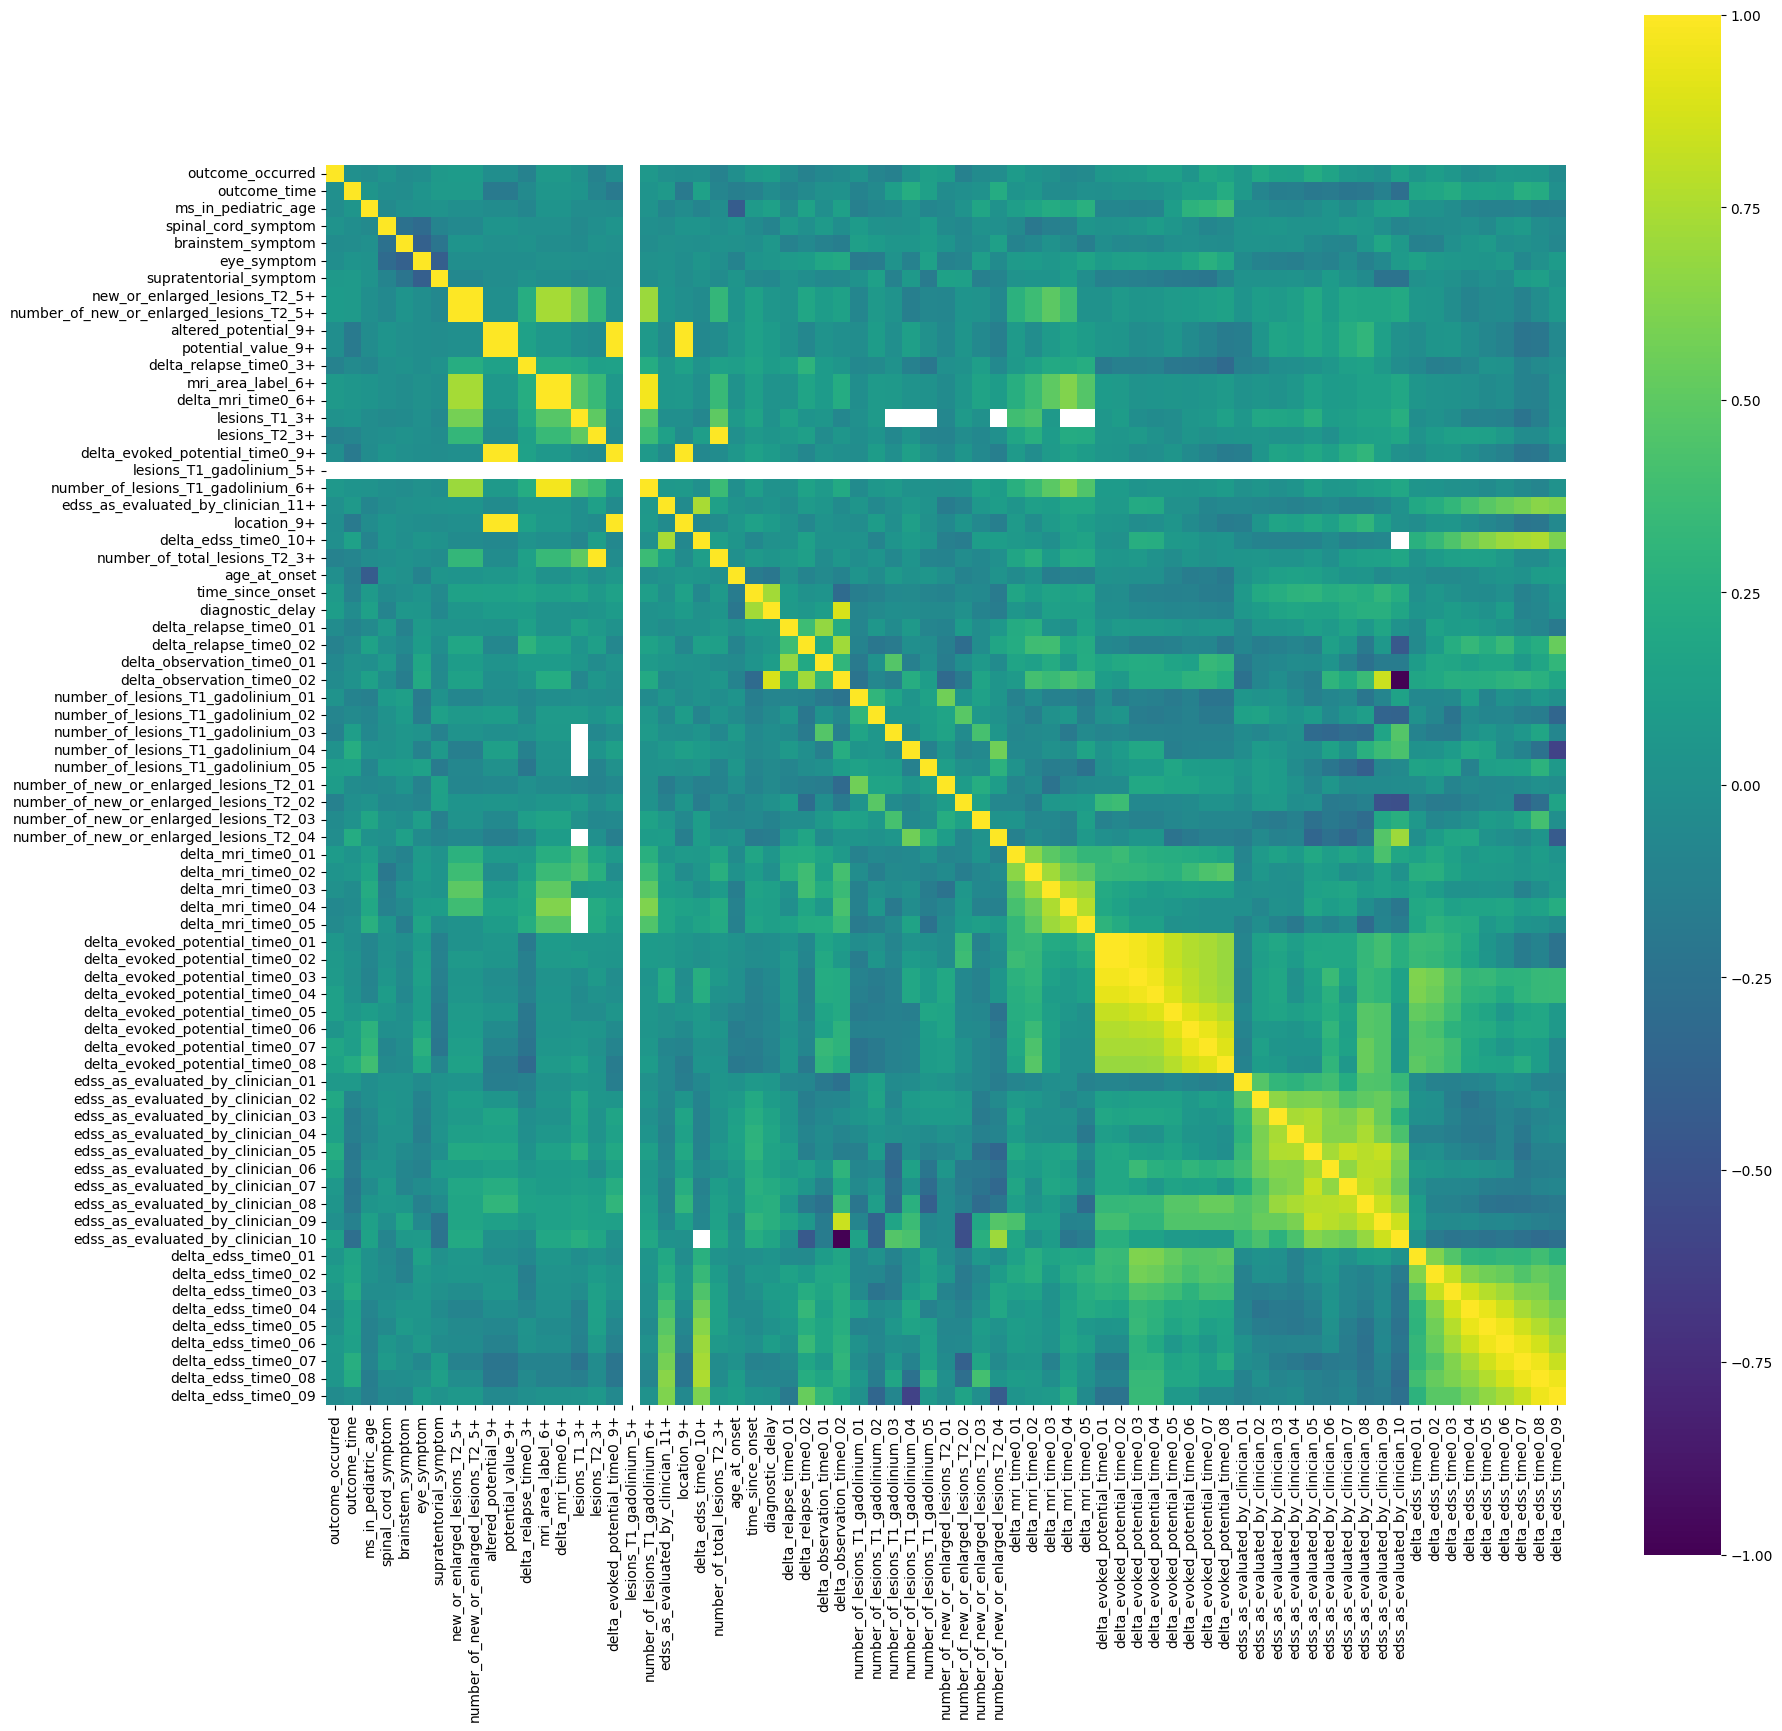

In [40]:
values = ['outcome_occurred', "outcome_time",'ms_in_pediatric_age', 'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom', 'supratentorial_symptom','new_or_enlarged_lesions_T2_5+', 'number_of_new_or_enlarged_lesions_T2_5+', 'altered_potential_9+', 'potential_value_9+', 'delta_relapse_time0_3+', 'mri_area_label_6+', 'delta_mri_time0_6+', 'lesions_T1_3+', 'lesions_T2_3+', 'delta_evoked_potential_time0_9+', 'lesions_T1_gadolinium_5+', 'number_of_lesions_T1_gadolinium_6+', 'edss_as_evaluated_by_clinician_11+', 'location_9+', 'delta_edss_time0_10+', 'number_of_total_lesions_T2_3+','age_at_onset', 'time_since_onset', 'diagnostic_delay', 'delta_relapse_time0_01', 'delta_relapse_time0_02', 'delta_observation_time0_01', 'delta_observation_time0_02', 'number_of_lesions_T1_gadolinium_01', 'number_of_lesions_T1_gadolinium_02', 'number_of_lesions_T1_gadolinium_03', 'number_of_lesions_T1_gadolinium_04', 'number_of_lesions_T1_gadolinium_05', 'number_of_new_or_enlarged_lesions_T2_01', 'number_of_new_or_enlarged_lesions_T2_02', 'number_of_new_or_enlarged_lesions_T2_03', 'number_of_new_or_enlarged_lesions_T2_04', 'delta_mri_time0_01', 'delta_mri_time0_02', 'delta_mri_time0_03', 'delta_mri_time0_04', 'delta_mri_time0_05', 'delta_evoked_potential_time0_01', 'delta_evoked_potential_time0_02', 'delta_evoked_potential_time0_03', 'delta_evoked_potential_time0_04', 'delta_evoked_potential_time0_05', 'delta_evoked_potential_time0_06', 'delta_evoked_potential_time0_07', 'delta_evoked_potential_time0_08', 'edss_as_evaluated_by_clinician_01', 'edss_as_evaluated_by_clinician_02', 'edss_as_evaluated_by_clinician_03', 'edss_as_evaluated_by_clinician_04', 'edss_as_evaluated_by_clinician_05', 'edss_as_evaluated_by_clinician_06', 'edss_as_evaluated_by_clinician_07', 'edss_as_evaluated_by_clinician_08', 'edss_as_evaluated_by_clinician_09', 'edss_as_evaluated_by_clinician_10', 'delta_edss_time0_01', 'delta_edss_time0_02', 'delta_edss_time0_03', 'delta_edss_time0_04', 'delta_edss_time0_05', 'delta_edss_time0_06', 'delta_edss_time0_07', 'delta_edss_time0_08', 'delta_edss_time0_09']
corr_mat = df[values].corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_mat,  vmax=1, cmap="viridis", square=True)




In [41]:
import fastcore
from fastai.tabular.all import RandomSplitter, range_of, TabularPandas, Categorify, FillMissing, Normalize

cols_typed = {"bool": ['ms_in_pediatric_age', 'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom', 'supratentorial_symptom'],
     "int32": ['new_or_enlarged_lesions_T2_5+', 'number_of_new_or_enlarged_lesions_T2_5+', 'altered_potential_9+', 'potential_value_9+', 'delta_relapse_time0_3+', 'mri_area_label_6+', 'delta_mri_time0_6+', 'lesions_T1_3+', 'lesions_T2_3+', 'delta_evoked_potential_time0_9+', 'lesions_T1_gadolinium_5+', 'number_of_lesions_T1_gadolinium_6+', 'edss_as_evaluated_by_clinician_11+', 'location_9+', 'delta_edss_time0_10+', 'number_of_total_lesions_T2_3+'],
     "int64": ['age_at_onset', 'time_since_onset'],
     "float64": ['diagnostic_delay', 'delta_relapse_time0_01', 'delta_relapse_time0_02', 'delta_observation_time0_01', 'delta_observation_time0_02', 'number_of_lesions_T1_gadolinium_01', 'number_of_lesions_T1_gadolinium_02', 'number_of_lesions_T1_gadolinium_03', 'number_of_lesions_T1_gadolinium_04', 'number_of_lesions_T1_gadolinium_05', 'number_of_new_or_enlarged_lesions_T2_01', 'number_of_new_or_enlarged_lesions_T2_02', 'number_of_new_or_enlarged_lesions_T2_03', 'number_of_new_or_enlarged_lesions_T2_04', 'delta_mri_time0_01', 'delta_mri_time0_02', 'delta_mri_time0_03', 'delta_mri_time0_04', 'delta_mri_time0_05', 'delta_evoked_potential_time0_01', 'delta_evoked_potential_time0_02', 'delta_evoked_potential_time0_03', 'delta_evoked_potential_time0_04', 'delta_evoked_potential_time0_05', 'delta_evoked_potential_time0_06', 'delta_evoked_potential_time0_07', 'delta_evoked_potential_time0_08', 'edss_as_evaluated_by_clinician_01', 'edss_as_evaluated_by_clinician_02', 'edss_as_evaluated_by_clinician_03', 'edss_as_evaluated_by_clinician_04', 'edss_as_evaluated_by_clinician_05', 'edss_as_evaluated_by_clinician_06', 'edss_as_evaluated_by_clinician_07', 'edss_as_evaluated_by_clinician_08', 'edss_as_evaluated_by_clinician_09', 'edss_as_evaluated_by_clinician_10', 'delta_edss_time0_01', 'delta_edss_time0_02', 'delta_edss_time0_03', 'delta_edss_time0_04', 'delta_edss_time0_05', 'delta_edss_time0_06', 'delta_edss_time0_07', 'delta_edss_time0_08', 'delta_edss_time0_09'],
     "object": [ 'sex', 'residence_classification', 'ethnicity', 'other_symptoms', 'centre', 'multiple_sclerosis_type_01', 'multiple_sclerosis_type_02', 'mri_area_label_01', 'mri_area_label_02', 'mri_area_label_03', 'mri_area_label_04', 'mri_area_label_05', 'lesions_T1_01', 'lesions_T1_02', 'lesions_T1_gadolinium_01', 'lesions_T1_gadolinium_02', 'new_or_enlarged_lesions_T2_01', 'new_or_enlarged_lesions_T2_02', 'new_or_enlarged_lesions_T2_03', 'new_or_enlarged_lesions_T2_04', 'lesions_T2_01', 'lesions_T2_02', 'number_of_total_lesions_T2_01', 'number_of_total_lesions_T2_02', 'altered_potential_01', 'altered_potential_02', 'altered_potential_03', 'altered_potential_04', 'altered_potential_05', 'altered_potential_06', 'altered_potential_07', 'altered_potential_08', 'potential_value_01', 'potential_value_02', 'potential_value_03', 'potential_value_04', 'potential_value_05', 'potential_value_06', 'potential_value_07', 'potential_value_08', 'location_01', 'location_02', 'location_03', 'location_04', 'location_05', 'location_06', 'location_07', 'location_08']}

cat_names = [*cols_typed["bool"], *cols_typed["object"]]
cont_names = [*cols_typed["int32"], *cols_typed["int64"], *cols_typed["float64"]]

splits = RandomSplitter(valid_pct=0.2)(range_of(df))

to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='outcome_occurred',
                   splits=splits)

In [42]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.ravel()

In [43]:
log_reg = LogisticRegression(max_iter=1000)
svc = SVC()
knn = KNeighborsClassifier(n_neighbors=5)
gauss = GaussianNB()
perceptron = Perceptron()
linear_svc = LinearSVC()
sgd = SGDClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators=200, n_jobs=-1)

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
                  gamma=0, gpu_id=-1, importance_type='gain',
                  interaction_constraints='', learning_rate=0.300000012,
                  max_delta_step=0, max_depth=10, min_child_weight=1,
                  monotone_constraints='()', n_estimators=1000, n_jobs=20,
                  num_parallel_tree=1, objective='binary:logistic', random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
                  tree_method='exact',
                  validate_parameters=1, verbosity=None)

lgm = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

models = [log_reg, svc, knn, gauss, perceptron, linear_svc, sgd, decision_tree, random_forest, xgb, lgm]


In [44]:
accuracies = {}

for model in models:
    model.fit(X_train, y_train)
    train_acc = round(model.score(X_train, y_train) * 100, 2)

    val_acc = round(model.score(X_valid, y_valid) * 100, 2)
    accuracies[model.__class__.__name__] = {"train_acc": train_acc, "val_acc": val_acc}


acc_df = pd.DataFrame(accuracies).transpose().sort_values("val_acc", ascending=False)
acc_df

c:\programming\python projects\idpp2023\idpp2023-kde-lab\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\programming\python projects\idpp2023\idpp2023-kde-lab\venv\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


,train_acc,val_acc
KNeighborsClassifier,87.78,81.82
LogisticRegression,95.45,80.68
RandomForestClassifier,100.00,80.68
SVC,85.23,79.55
LinearSVC,99.15,79.55
LGBMClassifier,100.00,79.55
SGDClassifier,88.92,78.41
DecisionTreeClassifier,100.00,78.41
XGBClassifier,100.00,77.27
Perceptron,75.57,63.64


In [45]:
coeff_df = pd.DataFrame(X_train.columns.values)
coeff_df.columns = ["Feature"]
coeff_df["Correlation"] = pd.Series(models[0].coef_[0])

coeff_df.sort_values("Correlation", ascending=False)

,Feature,Correlation
42,potential_value_06,1.168614
4,supratentorial_symptom,1.049347
1,spinal_cord_symptom,0.985320
53,diagnostic_delay_na,0.942438
8,other_symptoms,0.905397
93,delta_edss_time0_04_na,0.853766
38,potential_value_02,0.847930
58,number_of_lesions_T1_gadolinium_01_na,0.826074
126,number_of_lesions_T1_gadolinium_05,0.792763
16,mri_area_label_05,0.787844


# Regression

In [46]:
cols_typed = {"bool": ['ms_in_pediatric_age', 'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom', 'supratentorial_symptom'],
     "int32": ['new_or_enlarged_lesions_T2_5+', 'number_of_new_or_enlarged_lesions_T2_5+', 'altered_potential_9+', 'potential_value_9+', 'delta_relapse_time0_3+', 'mri_area_label_6+', 'delta_mri_time0_6+', 'lesions_T1_3+', 'lesions_T2_3+', 'delta_evoked_potential_time0_9+', 'lesions_T1_gadolinium_5+', 'number_of_lesions_T1_gadolinium_6+', 'edss_as_evaluated_by_clinician_11+', 'location_9+', 'delta_edss_time0_10+', 'number_of_total_lesions_T2_3+'],
     "int64": ['age_at_onset', 'time_since_onset', "outcome_occurred"],
     "float64": ['diagnostic_delay', 'outcome_time', 'delta_relapse_time0_01', 'delta_relapse_time0_02', 'delta_observation_time0_01', 'delta_observation_time0_02', 'number_of_lesions_T1_gadolinium_01', 'number_of_lesions_T1_gadolinium_02', 'number_of_lesions_T1_gadolinium_03', 'number_of_lesions_T1_gadolinium_04', 'number_of_lesions_T1_gadolinium_05', 'number_of_new_or_enlarged_lesions_T2_01', 'number_of_new_or_enlarged_lesions_T2_02', 'number_of_new_or_enlarged_lesions_T2_03', 'number_of_new_or_enlarged_lesions_T2_04', 'delta_mri_time0_01', 'delta_mri_time0_02', 'delta_mri_time0_03', 'delta_mri_time0_04', 'delta_mri_time0_05', 'delta_evoked_potential_time0_01', 'delta_evoked_potential_time0_02', 'delta_evoked_potential_time0_03', 'delta_evoked_potential_time0_04', 'delta_evoked_potential_time0_05', 'delta_evoked_potential_time0_06', 'delta_evoked_potential_time0_07', 'delta_evoked_potential_time0_08', 'edss_as_evaluated_by_clinician_01', 'edss_as_evaluated_by_clinician_02', 'edss_as_evaluated_by_clinician_03', 'edss_as_evaluated_by_clinician_04', 'edss_as_evaluated_by_clinician_05', 'edss_as_evaluated_by_clinician_06', 'edss_as_evaluated_by_clinician_07', 'edss_as_evaluated_by_clinician_08', 'edss_as_evaluated_by_clinician_09', 'edss_as_evaluated_by_clinician_10', 'delta_edss_time0_01', 'delta_edss_time0_02', 'delta_edss_time0_03', 'delta_edss_time0_04', 'delta_edss_time0_05', 'delta_edss_time0_06', 'delta_edss_time0_07', 'delta_edss_time0_08', 'delta_edss_time0_09'],
     "object": [ 'sex', 'residence_classification', 'ethnicity', 'other_symptoms', 'centre', 'multiple_sclerosis_type_01', 'multiple_sclerosis_type_02', 'mri_area_label_01', 'mri_area_label_02', 'mri_area_label_03', 'mri_area_label_04', 'mri_area_label_05', 'lesions_T1_01', 'lesions_T1_02', 'lesions_T1_gadolinium_01', 'lesions_T1_gadolinium_02', 'new_or_enlarged_lesions_T2_01', 'new_or_enlarged_lesions_T2_02', 'new_or_enlarged_lesions_T2_03', 'new_or_enlarged_lesions_T2_04', 'lesions_T2_01', 'lesions_T2_02', 'number_of_total_lesions_T2_01', 'number_of_total_lesions_T2_02', 'altered_potential_01', 'altered_potential_02', 'altered_potential_03', 'altered_potential_04', 'altered_potential_05', 'altered_potential_06', 'altered_potential_07', 'altered_potential_08', 'potential_value_01', 'potential_value_02', 'potential_value_03', 'potential_value_04', 'potential_value_05', 'potential_value_06', 'potential_value_07', 'potential_value_08', 'location_01', 'location_02', 'location_03', 'location_04', 'location_05', 'location_06', 'location_07', 'location_08']}

cat_names = [*cols_typed["bool"], *cols_typed["object"]]
cont_names = [*cols_typed["int32"], *cols_typed["int64"], *cols_typed["float64"]]

splits = RandomSplitter(valid_pct=0.2)(range_of(df))

to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='outcome_time',
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.ravel()

In [47]:
# y_train = df["outcome_time"]
# train_df = df.drop(["outcome_time", "patient_id"], axis=1)

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=43).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

## Models

In [48]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)
model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213,
                             random_state =7, nthread = -1)
model_lgb = lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

regressors = {"Lasso": lasso, "ElasticNet": ENet, "Kernel Ridge": KRR,
              "Gradient Boosting": GBoost, "XGBoost": model_xgb,
              "LGBM": model_lgb}

In [49]:
for model_name, model in regressors.items():
    score = rmsle_cv(model)
    print(f"{model_name} score: {score.mean():.4f} ({score.std():.4f})")

Lasso score: 0.0007 (0.0000)
ElasticNet score: 0.0008 (0.0000)
Kernel Ridge score: 0.1289 (0.0146)
Gradient Boosting score: 0.2806 (0.0207)
XGBoost score: 0.1934 (0.0200)
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. 

In [50]:
# sns.kdeplot(y_valid)
# print(min(y_valid), max(y_valid), 15/(max(y_valid)-min(y_valid)))
# tmp = 15/(max(y_valid)-min(y_valid))

In [51]:
mean, std = to.means["outcome_time"], to.stds["outcome_time"]

In [52]:
model = regressors["Lasso"]
model.fit(X_train, y_train)

preds = model.predict(X_valid)

pred_df = pd.DataFrame({"ground truth":y_valid*std + mean, "preds": preds*std + mean,
                        "MSE": ((y_valid*std + mean - (preds*std + mean))**2)/len(y_valid),
                        "MAE": (abs(y_valid*std + mean - (preds*std + mean)))/len(y_valid)})
print(f"Total error:\nMSE: {sum(pred_df['MSE'])}\tMAE: {sum(pred_df['MAE'])}")
pred_df.head(87)

# print(f"{model_name}: {val_acc}")


Total error:
MSE: 1.1877290149958979e-05	MAE: 0.0028492945983645975


,ground truth,preds,MSE,MAE
0,3.621918,3.622965,1.245436e-08,0.000012
1,2.512329,2.514212,4.029249e-08,0.000021
2,1.227397,1.230349,9.900882e-08,0.000034
3,10.350685,10.346724,1.782695e-07,0.000045
4,5.783562,5.783108,2.339774e-09,0.000005
5,15.000000,14.992566,6.280686e-07,0.000084
6,1.671233,1.673743,7.159671e-08,0.000029
7,11.027397,11.022932,2.265771e-07,0.000051
8,11.424658,11.419896,2.576306e-07,0.000054
9,3.465753,3.466926,1.561424e-08,0.000013


In [53]:
DATASET = "datasetB"
DATASET_DIR = f"../data/{DATASET}_train"

dfs = read_dfs(DATASET_DIR)
df = merge_csv_in_dir(dfs, DATASET)
df = df.dropna(axis=1, how="all")

df = collapse_cols(df, feats_to_be_collapsed)

cols_typed = {"bool": ['ms_in_pediatric_age', 'spinal_cord_symptom', 'brainstem_symptom', 'eye_symptom', 'supratentorial_symptom'],
     "int32": ['new_or_enlarged_lesions_T2_5+', 'number_of_new_or_enlarged_lesions_T2_5+', 'altered_potential_9+', 'potential_value_9+', 'delta_relapse_time0_3+', 'mri_area_label_6+', 'delta_mri_time0_6+', 'lesions_T1_3+', 'lesions_T2_3+', 'delta_evoked_potential_time0_9+', 'lesions_T1_gadolinium_5+', 'number_of_lesions_T1_gadolinium_6+', 'edss_as_evaluated_by_clinician_11+', 'location_9+', 'delta_edss_time0_10+', 'number_of_total_lesions_T2_3+'],
     "int64": ['age_at_onset', 'time_since_onset'],
     "float64": ['diagnostic_delay', 'delta_relapse_time0_01', 'delta_relapse_time0_02', 'delta_observation_time0_01', 'delta_observation_time0_02', 'number_of_lesions_T1_gadolinium_01', 'number_of_lesions_T1_gadolinium_02', 'number_of_lesions_T1_gadolinium_03', 'number_of_lesions_T1_gadolinium_04', 'number_of_lesions_T1_gadolinium_05', 'number_of_new_or_enlarged_lesions_T2_01', 'number_of_new_or_enlarged_lesions_T2_02', 'number_of_new_or_enlarged_lesions_T2_03', 'number_of_new_or_enlarged_lesions_T2_04', 'delta_mri_time0_01', 'delta_mri_time0_02', 'delta_mri_time0_03', 'delta_mri_time0_04', 'delta_mri_time0_05', 'delta_evoked_potential_time0_01', 'delta_evoked_potential_time0_02', 'delta_evoked_potential_time0_03', 'delta_evoked_potential_time0_04', 'delta_evoked_potential_time0_05', 'delta_evoked_potential_time0_06', 'delta_evoked_potential_time0_07', 'delta_evoked_potential_time0_08', 'edss_as_evaluated_by_clinician_01', 'edss_as_evaluated_by_clinician_02', 'edss_as_evaluated_by_clinician_03', 'edss_as_evaluated_by_clinician_04', 'edss_as_evaluated_by_clinician_05', 'edss_as_evaluated_by_clinician_06', 'edss_as_evaluated_by_clinician_07', 'edss_as_evaluated_by_clinician_08', 'edss_as_evaluated_by_clinician_09', 'edss_as_evaluated_by_clinician_10', 'delta_edss_time0_01', 'delta_edss_time0_02', 'delta_edss_time0_03', 'delta_edss_time0_04', 'delta_edss_time0_05', 'delta_edss_time0_06', 'delta_edss_time0_07', 'delta_edss_time0_08', 'delta_edss_time0_09'],
     "object": [ 'sex', 'residence_classification', 'ethnicity', 'other_symptoms', 'centre', 'multiple_sclerosis_type_01', 'multiple_sclerosis_type_02', 'mri_area_label_01', 'mri_area_label_02', 'mri_area_label_03', 'mri_area_label_04', 'mri_area_label_05', 'lesions_T1_01', 'lesions_T1_02', 'lesions_T1_gadolinium_01', 'lesions_T1_gadolinium_02', 'new_or_enlarged_lesions_T2_01', 'new_or_enlarged_lesions_T2_02', 'new_or_enlarged_lesions_T2_03', 'new_or_enlarged_lesions_T2_04', 'lesions_T2_01', 'lesions_T2_02', 'number_of_total_lesions_T2_01', 'number_of_total_lesions_T2_02', 'altered_potential_01', 'altered_potential_02', 'altered_potential_03', 'altered_potential_04', 'altered_potential_05', 'altered_potential_06', 'altered_potential_07', 'altered_potential_08', 'potential_value_01', 'potential_value_02', 'potential_value_03', 'potential_value_04', 'potential_value_05', 'potential_value_06', 'potential_value_07', 'potential_value_08', 'location_01', 'location_02', 'location_03', 'location_04', 'location_05', 'location_06', 'location_07', 'location_08']}

cat_names = [*cols_typed["bool"], *cols_typed["object"]]
cont_names = [*cols_typed["int32"], *cols_typed["int64"], *cols_typed["float64"]]

splits = RandomSplitter(valid_pct=0.2)(range_of(df))

to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='outcome_occurred',
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_valid, y_valid = to.valid.xs, to.valid.ys.values.ravel()


accuracies = {}

for model in models:
    # model.fit(X_train, y_train)
    train_acc = round(model.score(X_train, y_train) * 100, 2)

    val_acc = round(model.score(X_valid, y_valid) * 100, 2)
    accuracies[model.__class__.__name__] = {"train_acc": train_acc, "val_acc": val_acc}


acc_df = pd.DataFrame(accuracies).transpose().sort_values("val_acc", ascending=False)
acc_df

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- delta_edss_time0_01_na
